In [ ]:
!pip install --no-deps pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install pandas matplotlib networkx

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network

In [ ]:
# Load the grouped data with cluster labels
grouped_clusters = pd.read_csv("Clustered_By_Columns_labels.csv")

# Melt the data back to a long format to associate roles with clusters
long_format = grouped_clusters.melt(
    id_vars=["Cluster", "Cluster_label"],
    value_vars=["Developer", "Deployer", "Victim"],
    var_name="Role",
    value_name="Entities"
)

# Explode the entities list to create one row per entity
long_format = long_format.explode("Entities").dropna(subset=["Entities"])

# Save the long format with roles and clusters
long_format.to_csv("Mapped_Entities_With_Roles.csv", index=False)


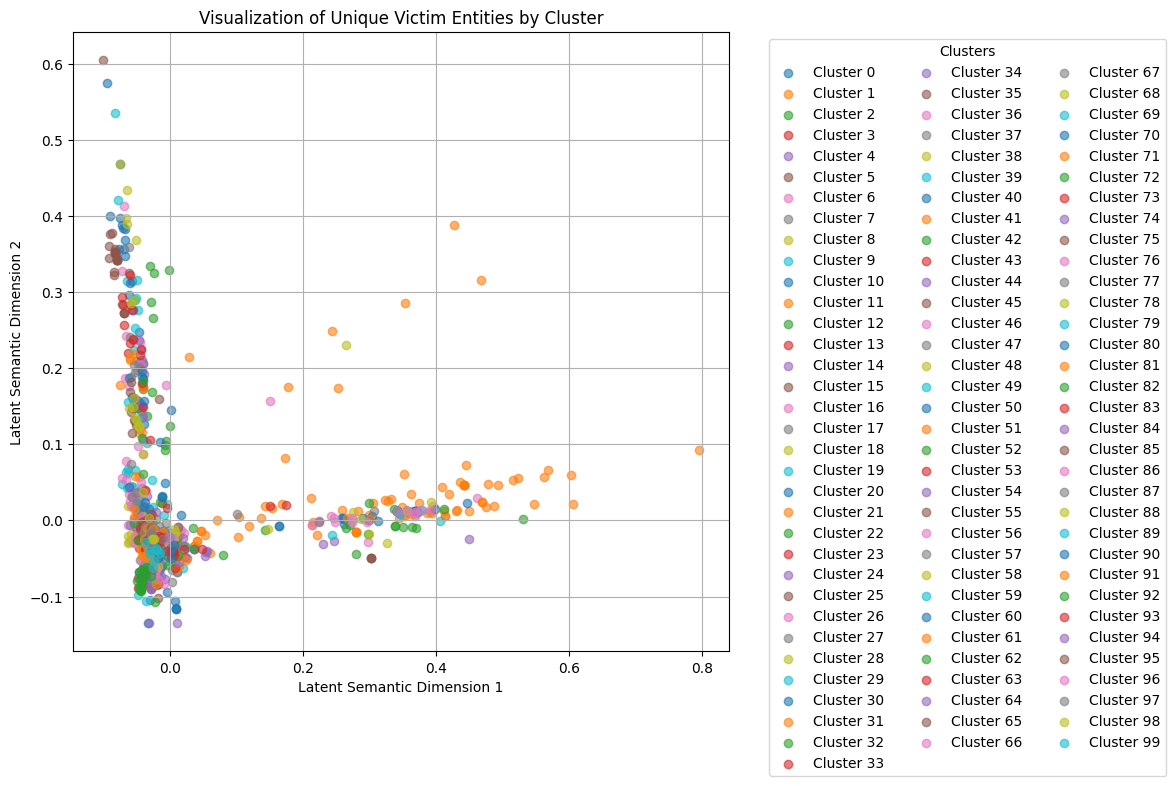

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import ast

# Step 1: Load and parse the data
file_path = 'Mapped_Entities_With_Roles.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

def parse_entities(entity_str):
    try:
        return ast.literal_eval(entity_str)
    except (ValueError, SyntaxError):
        return []

data['Entities'] = data['Entities'].apply(parse_entities)

# Step 2: Extract unique entities and their clusters
unique_entities = []
entity_cluster_map = {}

for _, row in data.iterrows():
    cluster = row['Cluster']
    for entity in row['Entities']:
        entity = entity.strip().lower()
        if entity not in entity_cluster_map:
            unique_entities.append(entity)
            entity_cluster_map[entity] = cluster

# Create a DataFrame for unique entities and their clusters
unique_entities_df = pd.DataFrame({
    'Entity': unique_entities,
    'Cluster': [entity_cluster_map[e] for e in unique_entities]
})

# Step 3: Vectorize the entities using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(unique_entities_df['Entity'])

# Step 4: Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Add PCA components to the DataFrame
unique_entities_df['PCA1'] = X_pca[:, 0]
unique_entities_df['PCA2'] = X_pca[:, 1]

# Step 5: Plot the results with an optimized legend layout
plt.figure(figsize=(12, 8))

# Sort clusters numerically for proper ordering in the legend
clusters = sorted(unique_entities_df['Cluster'].unique())  # Sort clusters in ascending order

for cluster in clusters:
    cluster_data = unique_entities_df[unique_entities_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', alpha=0.6)

# Better labels for PCA components
plt.title('Visualization of Unique Victim Entities by Cluster')
plt.xlabel('Latent Semantic Dimension 1')
plt.ylabel('Latent Semantic Dimension 2')
plt.grid(True)

# Adjust legend to be stacked with multiple columns to match the graph height
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)  # Increase the number of columns
plt.tight_layout()

# Save the plot as a transparent PNG
plt.savefig('cluster_visualization_transparent.png', format='png', dpi=300, transparent=True)
plt.show()


In [ ]:
import pandas as pd
import ast  # To safely evaluate stringified lists into actual lists

# Function to safely evaluate stringified lists in the 'Entities' column
def safely_evaluate_entities(entities):
    try:
        # Convert stringified list to Python list
        return ast.literal_eval(entities) if isinstance(entities, str) else []
    except (ValueError, SyntaxError):
        return []

# Load the long-format data (with Roles and Entities as lists)
long_format = pd.read_csv("Mapped_Entities_With_Roles.csv")

# Apply splitting logic to the 'Entities' column
long_format['Entities'] = long_format['Entities'].apply(safely_evaluate_entities)

# Explode the 'Entities' column to create one row per entity
long_format = long_format.explode('Entities').dropna(subset=['Entities'])

# Generate the nodes DataFrame
nodes = long_format[['Entities', 'Cluster_label']].drop_duplicates()
nodes['label'] = nodes['Entities']  # Optional: Use entity name as label

# Save the nodes to a CSV file
nodes.to_csv("network_nodes.csv", index=False)

print("Nodes file generated with individual entities.")


Nodes file generated with individual entities.


In [ ]:
nodes.head()

,Entities,Cluster_label,label
0,unicef,AI-Driven Platforms and Consumer Ecosystem,unicef
0,neusoft,AI-Driven Platforms and Consumer Ecosystem,neusoft
0,world food programme,AI-Driven Platforms and Consumer Ecosystem,world food programme
0,turnitin,AI-Driven Platforms and Consumer Ecosystem,turnitin
0,niantic labs,AI-Driven Platforms and Consumer Ecosystem,niantic labs


In [ ]:
import pandas as pd

# Load the original dataset
original_data = pd.read_csv("AI_Incident_Dataset.csv")

# Function to handle multiple entities in a column
def split_entities(column):
    return column.apply(lambda x: [e.strip() for e in x.split(',')] if isinstance(x, str) else [])

# Normalize the original data by splitting multi-entity fields
original_data['Developer'] = split_entities(original_data['Developer'])
original_data['Deployer'] = split_entities(original_data['Deployer'])
original_data['Victim'] = split_entities(original_data['Victim'])

# Generate edges
edges = []
for _, row in original_data.iterrows():
    # Create edges for Developers -> Deployers
    for developer in row['Developer']:
        for deployer in row['Deployer']:
            edges.append((developer, deployer, 'Deployed by'))
    # Create edges for Deployers -> Victims
    for deployer in row['Deployer']:
        for victim in row['Victim']:
            edges.append((deployer, victim, 'Harms'))
    # Create edges for Developers -> Victims
    for developer in row['Developer']:
        for victim in row['Victim']:
            edges.append((developer, victim, 'Directly harms'))

# Convert edges to a DataFrame
edges_df = pd.DataFrame(edges, columns=['source', 'target', 'relationship'])

# Save the edges file
edges_df.to_csv("network_edges.csv", index=False)

print("Edges file with updated relationships generated successfully!")


Edges file with updated relationships generated successfully!


In [ ]:
edges_df.tail()

,source,target,relationship
19838,reality defender,global south journalists,Harms
19839,reality defender,global south journalists,Directly harms
19840,reality defender,reality defender,Deployed by
19841,reality defender,civil society organizations in developing coun...,Harms
19842,reality defender,civil society organizations in developing coun...,Directly harms


In [12]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
from matplotlib import colormaps

# Load nodes and edges data
nodes = pd.read_csv("network_nodes.csv")  # Ensure this contains 'Entities', 'Cluster_label', 'label'
edges = pd.read_csv("network_edges.csv")  # Ensure this contains 'source', 'target', 'relationship'

# Add a 'label' column if missing
if 'label' not in nodes.columns:
    nodes['label'] = nodes['Entities']

# Initialize the graph
G = nx.Graph()

# Add nodes with attributes for clustering
for _, row in nodes.iterrows():
    G.add_node(row['Entities'], label=row['label'], Cluster_label=row['Cluster_label'])

# Add edges with relationship labels
for _, row in edges.iterrows():
    G.add_edge(row['source'], row['target'], relationship=row['relationship'])

# Initialize Pyvis network with white background
net = Network(notebook=True, height="1200px", width="100%", bgcolor="white", font_color="black")

# Define a larger colormap for cluster colors
clusters = nodes['Cluster_label'].unique()
cluster_colors = colormaps['hsv']  # Use HSV colormap for a full spectrum of colors
cluster_color_map = {
    cluster: f"#{int(255 * cluster_colors(i / len(clusters))[0]):02x}"
              f"{int(255 * cluster_colors(i / len(clusters))[1]):02x}"
              f"{int(255 * cluster_colors(i / len(clusters))[2]):02x}"
    for i, cluster in enumerate(clusters)
}

# Specify the nodes to highlight
highlight_nodes = ["tesla", "facebook", "google", "amazon"]  # Add the nodes you want to highlight
highlight_color_map = {
    "tesla": "#FF0000",  # Red
    "facebook": "#00FF00",  # Green
    "google": "#0000FF",  # Blue
    "amazon": "#FFFF00"  # Yellow
}
# Define unique edge highlight colors for each highlighted node
edge_highlight_color_map = {
    "tesla": "#FF0000",  # Red
    "facebook": "#00FF00",  # Green
    "google": "#0000FF",  # Blue
    "amazon": "#FFFF00"  # Yellow
}
# Add nodes with highlighting for the focus nodes
for node, data in G.nodes(data=True):
    cluster = data.get('Cluster_label', None)
    size = 30 if node in highlight_nodes else 10  # Larger size for highlighted nodes
    color = highlight_color_map.get(node, cluster_color_map.get(cluster, "#CCCCCC"))  # Use highlight color if applicable
    label = data.get('label', "")
    net.add_node(
        str(node), label=label, title=label,
        color=color, size=size
    )

# Add edges with unique colors for each highlighted node's connections
for u, v, data in G.edges(data=True):
    # Determine the edge color based on the highlighted nodes
    if u in highlight_nodes:
        edge_color = edge_highlight_color_map.get(u, "gray")
    elif v in highlight_nodes:
        edge_color = edge_highlight_color_map.get(v, "gray")
    else:
        edge_color = "gray"  # Default color for non-highlighted edges
    net.add_edge(str(u), str(v), title=data.get('relationship', ""), color=edge_color)


# Add legend for highlighted nodes and edges
legend_x, legend_y = 7000, 4800  # Position legend nodes away from the main graph
for node, color in highlight_color_map.items():
    legend_id = f"legend_highlight_{node}"
    net.add_node(
        legend_id, label=f"Node Highlight: {node}", color=color, size=20,
        x=legend_x, y=legend_y, physics=False
    )
    legend_y -= 100

for node, color in edge_highlight_color_map.items():
    legend_id = f"legend_edge_highlight_{node}"
    net.add_node(
        legend_id, label=f"Edge Highlight: {node}", color=color, size=15,
        x=legend_x, y=legend_y, physics=False
    )
    legend_y -= 100

# Use ForceAtlas2 for better node separation
net.force_atlas_2based(
    gravity=-50,
    central_gravity=0.01,
    spring_length=150,
    spring_strength=0.05,
    damping=0.4
)

# Save and show the graph
output_path = 'high.html'
net.show(output_path)

print(f"The graph with highlighted nodes '{highlight_nodes}' and custom edge colors has been saved as HTML at {output_path}.")


high.html
The graph with highlighted nodes '['tesla', 'facebook', 'google', 'amazon']' and custom edge colors has been saved as HTML at high.html.


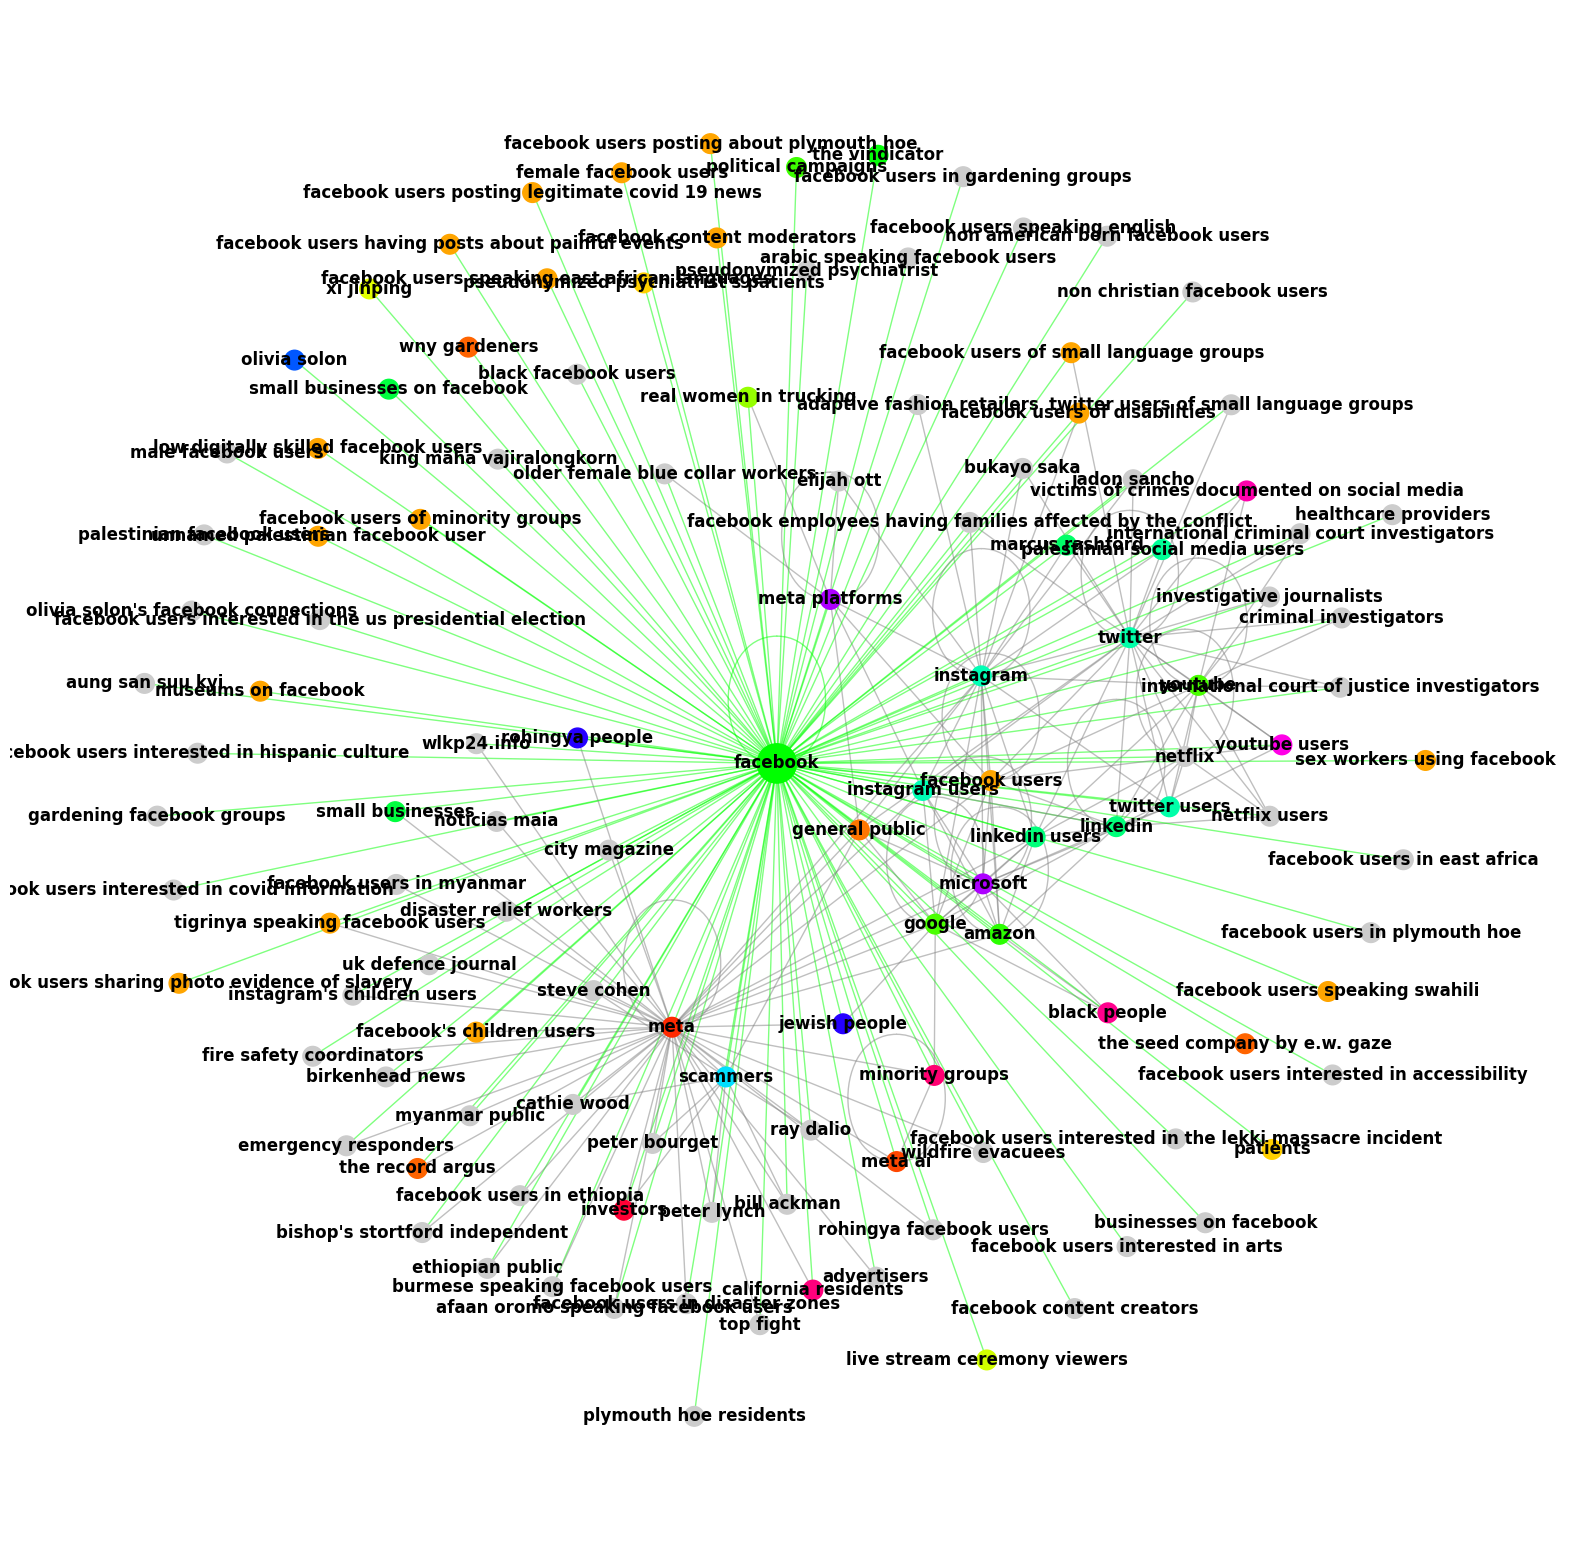

The transparent subgraph connected to 'facebook' has been saved as PNG at facebook_subgraph.png.


In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colormaps

# Load nodes and edges data
nodes = pd.read_csv("network_nodes.csv")  # Ensure this contains 'Entities', 'Cluster_label', 'label'
edges = pd.read_csv("network_edges.csv")  # Ensure this contains 'source', 'target', 'relationship'

# Add a 'label' column if missing
if 'label' not in nodes.columns:
    nodes['label'] = nodes['Entities']

# Initialize the graph
G = nx.Graph()

# Add nodes with attributes for clustering
for _, row in nodes.iterrows():
    G.add_node(row['Entities'], label=row['label'], Cluster_label=row['Cluster_label'])

# Add edges with relationship labels
for _, row in edges.iterrows():
    G.add_edge(row['source'], row['target'], relationship=row['relationship'])

# Extract the subgraph connected to "facebook"
source_node = "facebook"
ego_graph = nx.ego_graph(G, source_node)  # This includes "facebook" and its neighbors

# Define a larger colormap for cluster colors
clusters = nodes['Cluster_label'].unique()
cluster_colors = colormaps['hsv']  # Use HSV colormap for a full spectrum of colors
cluster_color_map = {
    cluster: cluster_colors(i / len(clusters)) for i, cluster in enumerate(clusters)
}

# Compute spring layout positions with adjusted spacing
spring_pos = nx.spring_layout(ego_graph, k=0.2, iterations=100)  # Reduce k for tighter spacing

# Draw the graph using Matplotlib
plt.figure(figsize=(20, 20), facecolor='none')  # Transparent background

# Draw nodes with varying sizes for importance
node_colors = [
    "#00FF00" if node == source_node else cluster_color_map.get(G.nodes[node].get('Cluster_label', None), "#CCCCCC")
    for node in ego_graph.nodes()
]
node_sizes = [800 if node == source_node else 200 for node in ego_graph.nodes()]  # Bigger size for important nodes
nx.draw_networkx_nodes(ego_graph, spring_pos, node_color=node_colors, node_size=node_sizes)

# Draw edges with reduced opacity
nx.draw_networkx_edges(
    ego_graph, spring_pos,
    edge_color=[
        "#00FF00" if source_node in (u, v) else "gray"
        for u, v in ego_graph.edges()
    ],
    alpha=0.5  # Reduced opacity for cleaner visuals
)

# Draw labels with increased font size
nx.draw_networkx_labels(
    ego_graph, spring_pos,
    labels={node: G.nodes[node].get('label', node) for node in ego_graph.nodes()},  # Use 'label' or fallback to node ID
    font_size=12, font_weight="bold"  # Larger font size
)

# Remove axis
plt.axis("off")

# Save the graph as a transparent PNG
output_path = "facebook_subgraph.png"
plt.savefig(output_path, format="png", dpi=300, bbox_inches="tight", transparent=True)  # Transparent background
plt.show()

print(f"The transparent subgraph connected to '{source_node}' has been saved as PNG at {output_path}.")
